In [1]:
import numpy as np

def PCA(n_components: int, data: np.ndarray, standardize: bool) -> np.ndarray :

    # Make a copy of data to avoid modifying the original
    data_copy = data.copy()
    
    # Data is assumed to contain information row wise
    
    # Feature wise standardize the data
    if standardize:
        data_copy = data_copy.T
        for i in range(data_copy.shape[0]):
            data_copy[i] = (data_copy[i] - np.mean(data_copy[i])) / np.std(data_copy[i])
        data_copy = data_copy.T

    # Covariance matrix computation
    covar_mat = np.zeros((data_copy.shape[1], data_copy.shape[1]))

    for i in range(data_copy.shape[1]):
        for j in range(data_copy.shape[1]):
            if j < i:
                continue

            col1 = data_copy[:, i:i+1]
            col2 = data_copy[:, j:j+1]

            cov = 0
            if standardize:
                cov = np.sum(col1 * col2) / data_copy.shape[0]  # Because standard distribution mean = 0
            else:
                cov = np.sum((col1 - np.mean(col1)) * (col2 - np.mean(col2))) / data_copy.shape[0]
            covar_mat[i][j] = cov
            covar_mat[j][i] = cov

    eigenvalues, eigenvectors = np.linalg.eigh(covar_mat)
    eigen_val_order = np.argsort(eigenvalues)[::-1]
    
    # Get the actual explained variance (eigenvalues)
    explained_variance = eigenvalues[eigen_val_order]
    
    # Select top n_components eigenvectors
    eigenvec_selected = eigenvectors[:, [eigen_val_order[i] for i in range(n_components)]]

    # Project data onto the principal components
    reduced_data = np.matmul(data_copy, eigenvec_selected)

    return reduced_data, eigenvec_selected, explained_variance[:n_components]

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("IRIS/iris.data", header=None, names=['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'type'])
target = df['type'].copy()
df.drop(["type"], axis=1, inplace=True)

print("Original data (first 5 rows): ")
print(df.head())

n_components = 2
standardize = True

reduced_data, components, explained_variance = PCA(n_components, df.to_numpy(), standardize)

print("Reduced data: ")
print(reduced_data[:5])

Original data (first 5 rows): 
   sepal_length  sepal_width  petal_length  petal_width
0           5.1          3.5           1.4          0.2
1           4.9          3.0           1.4          0.2
2           4.7          3.2           1.3          0.2
3           4.6          3.1           1.5          0.2
4           5.0          3.6           1.4          0.2
Reduced data: 
[[ 2.26454173  0.5057039 ]
 [ 2.0864255  -0.65540473]
 [ 2.36795045 -0.31847731]
 [ 2.30419716 -0.57536771]
 [ 2.38877749  0.6747674 ]]


In [3]:
# Scikit learn PCA
from sklearn.decomposition import PCA as sklearnPCA

sklearn_pca = sklearnPCA(n_components=n_components)

if standardize:
    # Standardize data for sklearn PCA
    data_std = np.zeros_like(df)
    df_np = df.to_numpy()
    for i in range(df.shape[1]):
        data_std[:, i] = (df_np[:, i] - np.mean(df_np[:, i])) / np.std(df_np[:, i])
    sklearn_reduced_data = sklearn_pca.fit_transform(data_std)
else:
    sklearn_reduced_data = sklearn_pca.fit_transform(df)

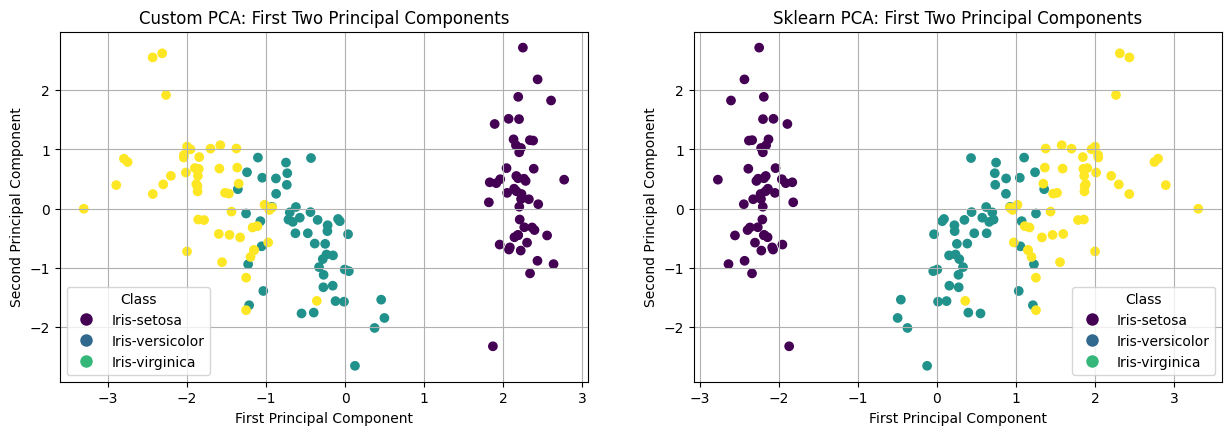

In [4]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)

# Convert target to numeric if it's not already
if not np.issubdtype(target.dtype, np.number):
    target_map = {label: i for i, label in enumerate(target.unique())}
    target_numeric = target.map(target_map)
else:
    target_numeric = target
    
# Create scatter plot with color based on class
scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=target_numeric, cmap='viridis')

# Add legend
if hasattr(target, 'unique'):
    unique_targets = target.unique()
    handles = [plt.Line2D([0], [0], marker='o', color='w', 
                            markerfacecolor=plt.cm.viridis(target_map[t]/len(target_map)) 
                            if not np.issubdtype(target.dtype, np.number) else plt.cm.viridis(t/len(unique_targets)), 
                            markersize=10) for t in unique_targets]
    plt.legend(handles, unique_targets, title="Class")
    
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Custom PCA: First Two Principal Components')
plt.grid(True)
    
# Plot 2: Scatter plot of first two PCs - Sklearn PCA
plt.subplot(2, 2, 2)
scatter = plt.scatter(sklearn_reduced_data[:, 0], sklearn_reduced_data[:, 1], c=target_numeric, cmap='viridis')
    
# Add a legend
if hasattr(target, 'unique'):
    plt.legend(handles, unique_targets, title="Class")
    
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Sklearn PCA: First Two Principal Components')
plt.grid(True)
    
plt.show()


Custom PCA explained variance: [2.91081808 0.92122093 0.14735328 0.02060771]
Sklearn PCA explained variance: [2.93035378 0.92740362 0.14834223 0.02074601]


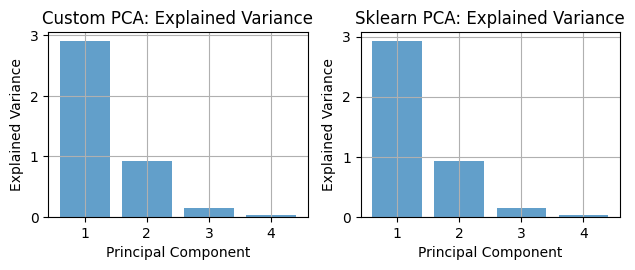

In [7]:
# Full explained variance
_, _, full_explained_variance = PCA(df.shape[1], df.to_numpy(), standardize)

plt.subplot(2, 2, 3)
components_range = range(1, len(full_explained_variance) + 1)
plt.bar(components_range, full_explained_variance, alpha=0.7)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.title('Custom PCA: Explained Variance')
plt.grid(True)

plt.subplot(2, 2, 4)
sklearn_full_pca = sklearnPCA(n_components=df.shape[1])
if standardize:
    sklearn_full_pca.fit(data_std)
else:
    sklearn_full_pca.fit(df.to_numpy())

plt.bar(components_range, sklearn_full_pca.explained_variance_, alpha=0.7)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.title('Sklearn PCA: Explained Variance')
plt.grid(True)

plt.tight_layout()

# Print comparison information
print("\nCustom PCA explained variance:", full_explained_variance)
print("Sklearn PCA explained variance:", sklearn_full_pca.explained_variance_)

plt.show()